# Tutorial — Privacidade em Biometria de Voz & Vozes Sintéticas

> **Pipeline:** Dataset (Hugging Face) → EDA → MFCC+LR → wav2vec2+MLP → Calibração → MIA → ECAPA (Top‑k) → Subset offline.


In [1]:
#@title Instalação e versões (Colab-ready)
%pip -q install --upgrade pip
%pip -q install datasets==2.* librosa==0.10.* soundfile scikit-learn numpy pandas matplotlib transformers accelerate torchaudio torch --progress-bar off
%pip -q install evaluate speechbrain tqdm --progress-bar off

import os, sys, platform, warnings, random, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torchaudio
import librosa
import datasets
import transformers
import evaluate

print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("torch:", torch.__version__, "| torchaudio:", torchaudio.__version__)
print("librosa:", librosa.__version__, "| datasets:", datasets.__version__)
print("transformers:", transformers.__version__, "| accelerate:", transformers.__version__)
print("CUDA disponível?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
Python: 3.12.12
OS: Linux-6.6.105+-x86_64-with-glibc2.35
torch: 2.8.0+cu126 | torchaudio: 2.8.0+cu126
librosa: 0.10.2.post1 | datasets: 2.21.0
transformers: 4.57.1 | accelerate: 4.57.1
CUDA disponível? True
GPU: Tesla T4


In [2]:
#@title Configuração de execução (ajuste aqui)
FAST_MODE = True  #@param {type:"boolean"}
N = 5000          #@param {type:"integer"}
TARGET_SR = 16000 #@param {type:"integer"}
MAX_LEN_S = 5.0   #@param {type:"number"}

LIMIT_MFCC = 2000 if FAST_MODE else 5000  #@param {type:"integer"}
LIMIT_W2V  = 1000 if FAST_MODE else 3000  #@param {type:"integer"}
BATCH_W2V  = 4     #@param {type:"integer"}
K_SPK      = 20    #@param {type:"integer"}
RANDOM_STATE = 42  #@param {type:"integer"}

import numpy as np, random, torch
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = int(MAX_LEN_S * TARGET_SR)
print(f"FAST_MODE={FAST_MODE} | N={N} | LIMIT_MFCC={LIMIT_MFCC} | LIMIT_W2V={LIMIT_W2V} | DEVICE={DEVICE}")


FAST_MODE=True | N=5000 | LIMIT_MFCC=2000 | LIMIT_W2V=1000 | DEVICE=cuda


In [7]:
# Carregar dataset balanceado (duas classes garantidas)
from datasets import load_dataset, Audio, ClassLabel
import numpy as np, pandas as pd

DS_NAME = "Shahzaib-Arshad/audio-fake-real-dataset"

def _norm_label(v):
    if isinstance(v, str):
        v = v.strip().lower()
        if v in {"real","genuine","human"}: return 0
        if v in {"fake","synthetic","ai","synth"}: return 1
    return int(v)

def load_audio_dataset_balanced(
    ds_name=DS_NAME, n=5000, sr=16000, seed=42, balance=True, max_per_class=None
):
    ds_full = load_dataset(ds_name, split="train")
    if "audio" not in ds_full.features:
        raise RuntimeError("Coluna 'audio' ausente no dataset.")
    ds_full = ds_full.cast_column("audio", Audio(sampling_rate=sr))

    # normalizar rótulos para 0 (real) e 1 (fake)
    lab = np.array([_norm_label(v) for v in ds_full["label"]], dtype=int)
    idx0 = np.where(lab == 0)[0].tolist()  # real
    idx1 = np.where(lab == 1)[0].tolist()  # fake
    if len(idx0) == 0 or len(idx1) == 0:
        raise ValueError("O dataset inteiro parece ter uma única classe.")

    rng = np.random.default_rng(seed)
    rng.shuffle(idx0); rng.shuffle(idx1)

    if balance:
        k = min(len(idx0), len(idx1), (n // 2))
        if max_per_class is not None:
            k = min(k, max_per_class)
        sel = idx0[:k] + idx1[:k]
    else:
        # amostragem proporcional simples
        k0 = min(len(idx0), n // 2)
        k1 = min(len(idx1), n - k0)
        sel = idx0[:k0] + idx1[:k1]

    rng.shuffle(sel)
    ds = ds_full.select(sel)
    y = np.array([_norm_label(v) for v in ds["label"]], dtype=int)
    return ds, y

# use seus hiperparâmetros aqui:
ds, y = load_audio_dataset_balanced(n=N, sr=TARGET_SR, seed=RANDOM_STATE, balance=True)

print("Amostras:", len(ds))
vals, cnts = np.unique(y, return_counts=True)
print("Distribuição por classe:", dict(zip(vals, cnts)))
assert len(np.unique(y)) == 2, "Ainda caiu em uma classe só."


Amostras: 5000
Distribuição por classe: {np.int64(0): np.int64(2500), np.int64(1): np.int64(2500)}


CV AUC (5-fold): [np.float64(0.9435), np.float64(0.9614), np.float64(0.9569), np.float64(0.9375), np.float64(0.9515)] | média = 0.9502
ROC-AUC (teste): 0.9437
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       206
           1       0.86      0.84      0.85       194

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



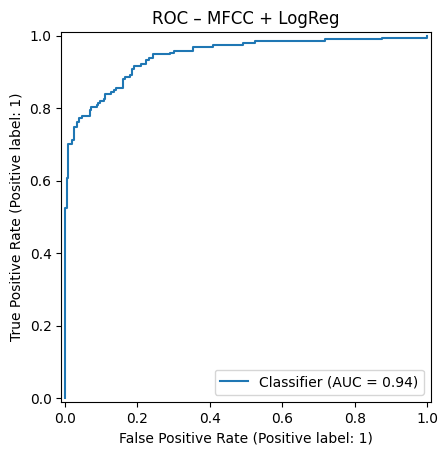

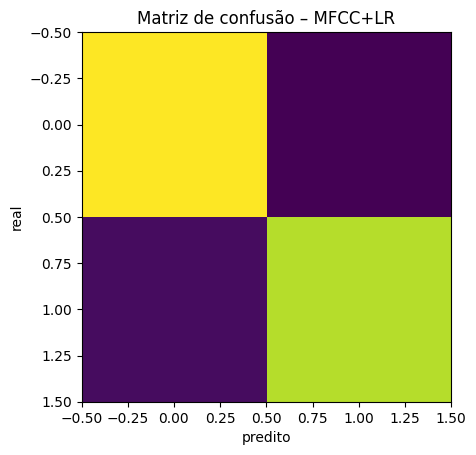

Tempo (s): 0.6


In [8]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix
import numpy as np, matplotlib.pyplot as plt, time

LIMIT_EFF = min(LIMIT_MFCC, len(ds))  # não ultrapassar o tamanho real
Xw = [ds[i]["audio"]["array"].astype(np.float32) for i in range(LIMIT_EFF)]

def to_mfcc_mean(wav, sr=TARGET_SR, n_mfcc=40):
    wav = wav if len(wav) >= int(MAX_LEN_S*sr) else np.pad(wav, (0, int(MAX_LEN_S*sr)-len(wav)))
    mfcc = librosa.feature.mfcc(y=wav[:int(MAX_LEN_S*sr)], sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1).astype(np.float32)

X = np.stack([to_mfcc_mean(w) for w in Xw])
y_sub = y[:len(X)]

# sanidade: precisamos de 2 classes
if len(np.unique(y_sub)) < 2:
    raise RuntimeError("Subset ainda está com uma classe. Aumente N ou desative FAST_MODE.")

# CV com nº de folds limitado pelo menor tamanho de classe
min_per_class = int(min(np.bincount(y_sub)))
n_splits = max(2, min(5, min_per_class))
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

auc_scores = []
t0 = time.time()
for tr, va in cv.split(X, y_sub):
    pipe = make_pipeline(StandardScaler(),
                         LogisticRegression(max_iter=2000, class_weight="balanced"))
    pipe.fit(X[tr], y_sub[tr])
    proba = pipe.predict_proba(X[va])[:, 1]
    auc_scores.append(roc_auc_score(y_sub[va], proba))
print(f"CV AUC ({n_splits}-fold):", [round(a,4) for a in auc_scores],
      "| média =", round(float(np.mean(auc_scores)),4))

# split final (estratificado)
Xtr, Xte, ytr, yte = train_test_split(X, y_sub, test_size=0.2, stratify=y_sub, random_state=RANDOM_STATE)
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(max_iter=2000, class_weight="balanced"))
clf.fit(Xtr, ytr)
proba_tr = clf.predict_proba(Xtr)[:,1]
proba_te = clf.predict_proba(Xte)[:,1]
print("ROC-AUC (teste):", round(roc_auc_score(yte, proba_te), 4))
print(classification_report(yte, clf.predict(Xte)))

RocCurveDisplay.from_predictions(yte, proba_te)
plt.title("ROC – MFCC + LogReg")
plt.show()

cm = confusion_matrix(yte, clf.predict(Xte))
plt.imshow(cm); plt.title("Matriz de confusão – MFCC+LR")
plt.xlabel("predito"); plt.ylabel("real"); plt.show()
print("Tempo (s):", round(time.time()-t0,1))


In [9]:
#@title Utilidades de áudio e extração de features
import numpy as np, librosa

def fix_length(wav: np.ndarray, max_len: int):
    if wav.shape[0] >= max_len:
        return wav[:max_len]
    out = np.zeros(max_len, dtype=wav.dtype)
    out[:wav.shape[0]] = wav
    return out

def to_mfcc_mean(wav: np.ndarray, sr: int, max_len: int, n_mfcc: int = 40):
    wav = fix_length(wav, max_len)
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1).astype(np.float32)

def collect_waveforms(dataset, limit=None):
    Xw = []
    lim = len(dataset) if limit is None else min(limit, len(dataset))
    for i in range(lim):
        wav = dataset[i]["audio"]["array"]
        Xw.append(wav.astype(np.float32))
    return Xw


CV AUC (5-fold): [np.float64(0.9434), np.float64(0.9612), np.float64(0.957), np.float64(0.9377), np.float64(0.9515)]  | média = 0.9502
ROC-AUC (teste): 0.9438
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       206
           1       0.87      0.84      0.86       194

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



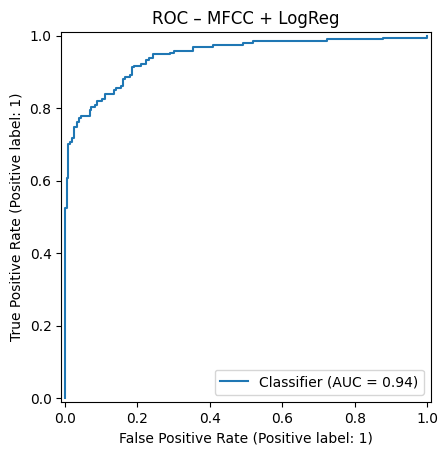

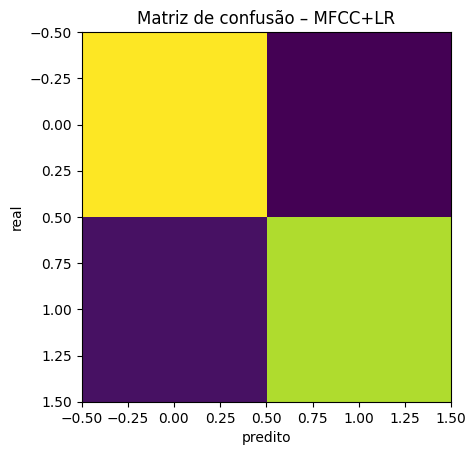

Tempo (s): 0.4


In [10]:
#@title Baseline MFCC + LogReg (CV + métrica final)
import numpy as np, time
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt

LIMIT = int(LIMIT_MFCC)
Xw = collect_waveforms(ds, LIMIT)
X = np.stack([to_mfcc_mean(w, TARGET_SR, MAX_LEN) for w in Xw])
y_sub = y[:len(X)]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
auc_scores = []
t0 = time.time()
for tr, va in cv.split(X, y_sub):
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, n_jobs=None))
    pipe.fit(X[tr], y_sub[tr])
    proba = pipe.predict_proba(X[va])[:,1]
    auc_scores.append(roc_auc_score(y_sub[va], proba))
print("CV AUC (5-fold):", [round(a,4) for a in auc_scores], " | média =", round(float(np.mean(auc_scores)),4))

Xtr, Xte, ytr, yte = train_test_split(X, y_sub, test_size=0.2, stratify=y_sub, random_state=RANDOM_STATE)
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
clf.fit(Xtr, ytr)
proba_tr = clf.predict_proba(Xtr)[:,1]
proba_te = clf.predict_proba(Xte)[:,1]
auc = roc_auc_score(yte, proba_te)
print("ROC-AUC (teste):", round(auc,4))
print(classification_report(yte, clf.predict(Xte)))

RocCurveDisplay.from_predictions(yte, proba_te)
plt.title("ROC – MFCC + LogReg")
plt.show()

cm = confusion_matrix(yte, clf.predict(Xte))
plt.figure()
plt.imshow(cm)
plt.title("Matriz de confusão – MFCC+LR")
plt.xlabel("predito"); plt.ylabel("real")
plt.show()
print("Tempo (s):", round(time.time()-t0,1))


Temperature* = 1.1
ECE train: 0.424 → 0.419
ECE test : 0.405 → 0.388
NLL test : 0.302 → 0.300
MIA AUC  : 0.509 → 0.509


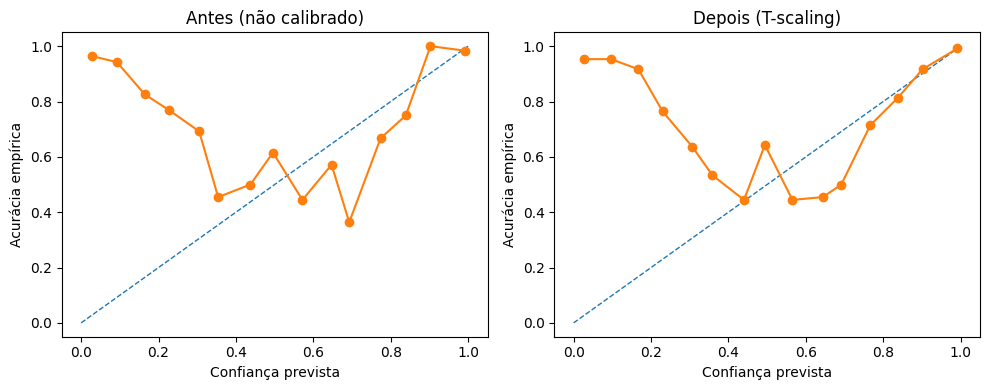

In [11]:
#@title Calibração (Temperature Scaling) + ECE + MIA
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss

def ece(probs, y_true, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(probs, bins) - 1
    ece_val, total = 0.0, len(probs)
    for b in range(n_bins):
        mask = idx == b
        if not np.any(mask):
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5)).mean()
        ece_val += abs(acc - conf) * (mask.sum()/total)
    return ece_val

def reliability_plot(ax, probs, y_true, n_bins=15, title="Reliability"):
    bins = np.linspace(0.0,1.0,n_bins+1)
    idx = np.digitize(probs, bins)-1
    xs, ys = [], []
    for b in range(n_bins):
        mask = idx == b
        if not np.any(mask):
            continue
        xs.append(np.clip(probs[mask].mean(), 1e-6, 1-1e-6))
        ys.append((y_true[mask] == (probs[mask] >= 0.5)).mean())
    ax.plot([0,1],[0,1],'--',linewidth=1)
    ax.plot(xs, ys, marker='o')
    ax.set_xlabel("Confiança prevista"); ax.set_ylabel("Acurácia empírica"); ax.set_title(title)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def fit_temperature(clf, X_val, y_val, grid=None):
    if hasattr(clf, "decision_function"):
        logits_val = clf.decision_function(X_val)
    else:
        p = clf.predict_proba(X_val)[:,1]
        eps = 1e-6
        logits_val = np.log(np.clip(p,eps,1-eps) / np.clip(1-p,eps,1-eps))
    if grid is None:
        grid = np.linspace(0.5, 3.0, 51)
    best_T, best_loss = None, float("inf")
    for T in grid:
        p = sigmoid(logits_val / T)
        ll = log_loss(y_val, p, labels=[0,1])
        if ll < best_loss:
            best_loss, best_T = ll, T
    return best_T

X_cal, y_cal = Xte, yte
T_star = fit_temperature(clf, X_cal, y_cal)
print("Temperature* =", round(T_star,3))

logit_tr = clf.decision_function(Xtr) if hasattr(clf, "decision_function") else None
logit_te = clf.decision_function(Xte) if hasattr(clf, "decision_function") else None

if logit_tr is None:
    eps=1e-6
    logit_tr = np.log(np.clip(proba_tr,eps,1-eps)/np.clip(1-proba_tr,eps,1-eps))
    logit_te = np.log(np.clip(proba_te,eps,1-eps)/np.clip(1-proba_te,eps,1-eps))

p_tr_cal = sigmoid(logit_tr / T_star)
p_te_cal = sigmoid(logit_te / T_star)

def confidence(p): return np.maximum(p, 1-p)

from sklearn.metrics import roc_auc_score
ece_tr_b = ece(proba_tr, ytr); ece_te_b = ece(proba_te, yte)
ece_tr_a = ece(p_tr_cal, ytr); ece_te_a = ece(p_te_cal, yte)
from sklearn.metrics import log_loss
nll_b = log_loss(yte, proba_te, labels=[0,1])
nll_a = log_loss(yte, p_te_cal, labels=[0,1])
mia_before = roc_auc_score(np.r_[np.ones_like(proba_tr), np.zeros_like(proba_te)], np.r_[confidence(proba_tr), confidence(proba_te)])
mia_after  = roc_auc_score(np.r_[np.ones_like(p_tr_cal), np.zeros_like(p_te_cal)], np.r_[confidence(p_tr_cal), confidence(p_te_cal)])

print(f"ECE train: {ece_tr_b:.3f} → {ece_tr_a:.3f}")
print(f"ECE test : {ece_te_b:.3f} → {ece_te_a:.3f}")
print(f"NLL test : {nll_b:.3f} → {nll_a:.3f}")
print(f"MIA AUC  : {mia_before:.3f} → {mia_after:.3f}")

fig, axs = plt.subplots(1,2, figsize=(10,4))
reliability_plot(axs[0], proba_te, yte, title="Antes (não calibrado)")
reliability_plot(axs[1], p_te_cal, yte, title="Depois (T-scaling)")
plt.tight_layout(); plt.show()


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/250 [00:00<?, ?it/s]

ROC-AUC (wav2vec2+MLP): 0.8939


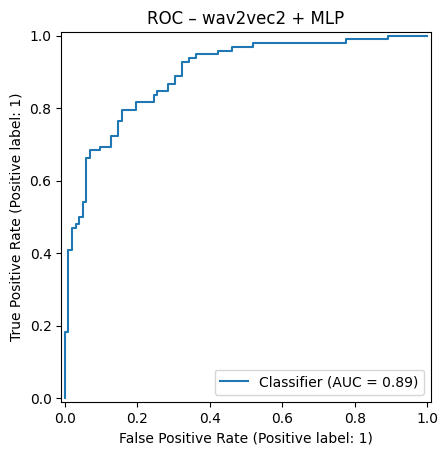

In [12]:
#@title Embeddings wav2vec2 (batched) + MLP
import numpy as np, torch, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoProcessor, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.neural_network import MLPClassifier

proc = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
w2v = AutoModel.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE).eval()

def emb_w2v_batch(wavs, sr=TARGET_SR, batch=BATCH_W2V):
    E = []
    with torch.inference_mode():
        for i in tqdm(range(0, len(wavs), batch)):
            chunk = [fix_length(w, MAX_LEN) for w in wavs[i:i+batch]]
            inputs = proc(chunk, sampling_rate=sr, return_tensors="pt", padding=True)
            inputs = {k: v.to(DEVICE) for k,v in inputs.items()}
            h = w2v(**inputs).last_hidden_state  # [B,T,C]
            e = h.mean(dim=1).detach().cpu().numpy()
            E.append(e)
    return np.concatenate(E, axis=0)

LIMIT = int(LIMIT_W2V)
Xw2 = collect_waveforms(ds, LIMIT)
X2 = emb_w2v_batch(Xw2)
y2 = y[:len(X2)]

X2tr, X2te, y2tr, y2te = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=RANDOM_STATE)
mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=60, random_state=RANDOM_STATE)
mlp.fit(X2tr, y2tr)
p2 = mlp.predict_proba(X2te)[:,1]
auc2 = roc_auc_score(y2te, p2)
print("ROC-AUC (wav2vec2+MLP):", round(auc2,4))

RocCurveDisplay.from_predictions(y2te, p2)
plt.title("ROC – wav2vec2 + MLP")
plt.show()


DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


hyperparams.yaml: 0.00B [00:00, ?B/s]

INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cache/huggingface/hub/models--speechb

Top-1: 1.0  | Top-5: 1.0


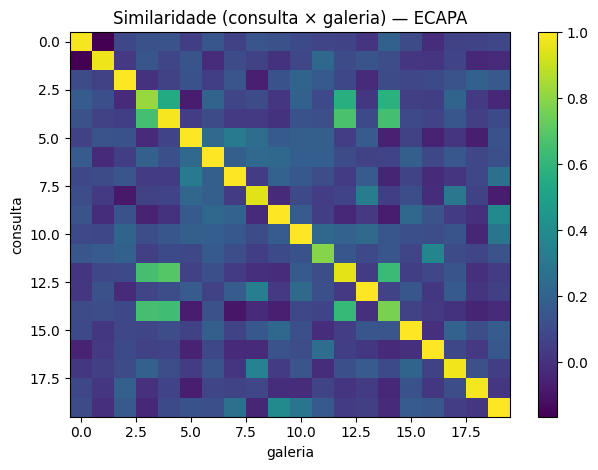

In [13]:
#@title Reidentificação (ECAPA) — Top‑k retrieval + heatmap
import numpy as np, matplotlib.pyplot as plt, torch
from sklearn.metrics.pairwise import cosine_similarity
from speechbrain.pretrained import EncoderClassifier

spk = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb",
                                     run_opts={"device": DEVICE})

def segment(wav, sr, seg_len_s=3.0, seed=None):
    rng = np.random.default_rng(seed)
    L = int(seg_len_s * sr)
    if len(wav) <= L:
        return wav
    start = rng.integers(0, len(wav)-L)
    return wav[start:start+L]

def emb_spk_batch(wavs, sr=TARGET_SR, max_len=MAX_LEN, batch=8):
    import torch, numpy as np
    E = []
    with torch.inference_mode():
        for i in range(0, len(wavs), batch):
            chunk = []
            for w in wavs[i:i+batch]:
                w = segment(w, sr, seg_len_s=min(MAX_LEN_S, 3.0))
                w = w[:max_len]
                if len(w) < max_len:
                    tmp = np.zeros(max_len, dtype=w.dtype)
                    tmp[:len(w)] = w; w = tmp
                chunk.append(torch.tensor(w).unsqueeze(0))
            W = torch.cat(chunk, dim=0).to(DEVICE)
            emb = spk.encode_batch(W).squeeze(1).detach().cpu().numpy()
            E.append(emb)
    return np.concatenate(E, axis=0)

M = int(min(K_SPK, len(ds)))
wavs = [ds[i]["audio"]["array"].astype(np.float32) for i in range(M)]
gallery = [segment(w, TARGET_SR, 3.0, seed=0) for w in wavs]
query   = [segment(w, TARGET_SR, 3.0, seed=1) for w in wavs]

E_g = emb_spk_batch(gallery)
E_q = emb_spk_batch(query)
S = cosine_similarity(E_q, E_g)

top1 = (S.argmax(axis=1) == np.arange(S.shape[0])).mean()
top5 = (np.argsort(-S, axis=1)[:, :5] == np.arange(S.shape[0])[:, None]).any(axis=1).mean()

print("Top-1:", round(float(top1),3), " | Top-5:", round(float(top5),3))

plt.figure()
plt.imshow(S, aspect="auto")
plt.colorbar()
plt.title("Similaridade (consulta × galeria) — ECAPA")
plt.xlabel("galeria"); plt.ylabel("consulta")
plt.tight_layout(); plt.show()


In [14]:
#@title Plano B: salvar subset local (WAV + meta.csv)
import os, pandas as pd, soundfile as sf
from tqdm.auto import tqdm

outdir = "/content/data/subset"
os.makedirs(outdir, exist_ok=True)

M = 100  # número de amostras para exportar
rows = []
for i in tqdm(range(min(M, len(ds)))):
    wav = ds[i]["audio"]["array"]
    path = os.path.join(outdir, f"sample_{i:05d}.wav")
    sf.write(path, wav, TARGET_SR)
    rows.append({"path": path, "label": int(y[i])})

pd.DataFrame(rows).to_csv(os.path.join(outdir, "meta.csv"), index=False)
print("Subset salvo em:", outdir)


  0%|          | 0/100 [00:00<?, ?it/s]

Subset salvo em: /content/data/subset


## Referências rápidas (contexto técnico)
- Shokri et al., *Membership Inference Attacks Against Machine Learning Models* (IEEE S&P, 2017).
- Guo et al., *On Calibration of Modern Neural Networks* (ICML, 2017).
- Desplanques et al., *ECAPA-TDNN* (Interspeech, 2020).
- Surveys de detecção de áudio deepfake (artefatos, generalização).
